# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  13%|███████████████████████▎                                                                                                                                                            | 14/108 [00:00<00:02, 35.10it/s]OpenCV: Couldn't read video stream from file "behavior_data/shorter_armflapping/.DS_Store"
[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/videoio/src/cap.cpp (162) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): behavior_data/shorter_armflapping/.DS_Store in function 'icvExtractPattern'


armflapping_videos:  17%|██████████████████████████████                                                                                                                         

failed on .DS_Store


control_videos:  19%|███████████████████████████████████▊                                                                                                                                                     | 12/62 [00:00<00:03, 14.22it/s]OpenCV: Couldn't read video stream from file "behavior_data/shorter_control/.DS_Store"
[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/videoio/src/cap.cpp (162) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): behavior_data/shorter_control/.DS_Store in function 'icvExtractPattern'


control_videos:  23%|█████████████████████████████████████████▊                                                                                                                         

failed on .DS_Store


control_videos: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 19.94it/s]


(97, 50)

In [ ]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

 11%|█▏        | 11/97 [00:26<03:25,  2.39s/it]


KeyboardInterrupt: 

In [5]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

NameError: name 'ARMFLAPPING_LOCATIONS' is not defined

In [6]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 

X, y = generate_data(padded_armflapping_locations, padded_control_locations)

NameError: name 'padded_armflapping_locations' is not defined

In [14]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [5]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [6]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [7]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [8]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [9]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [10]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed = 68)

In [11]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [12]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.7227 - accuracy: 0.4375 - precision_3: 0.4255 - recall_3: 0.5263 - val_loss: 0.6545 - val_accuracy: 0.6500 - val_precision_3: 1.0000 - val_recall_3: 0.4167
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6588 - accuracy: 0.6750 - precision_3: 0.8000 - recall_3: 0.4211 - val_loss: 0.5780 - val_accuracy: 0.7500 - val_precision_3: 0.7692 - val_recall_3: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6502 - accuracy: 0.6625 - precision_3: 0.6038 - recall_3: 0.8421 - val_loss: 0.5537 - val_accuracy: 0.6500 - val_precision_3: 0.6667 - val_recall_3: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.5864 - accuracy: 0.7500 - precision_3: 0.7045 - recall_3: 0.8158 - val_loss: 0.8587 - val_accuracy: 0.6000 - val_precision_3: 0.8333 - val_recall_3: 0.4167
Epoch 5/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7318 -

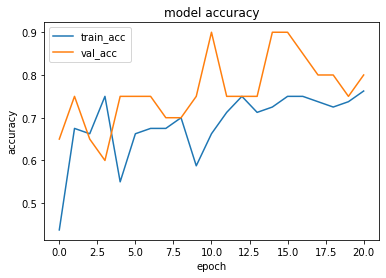

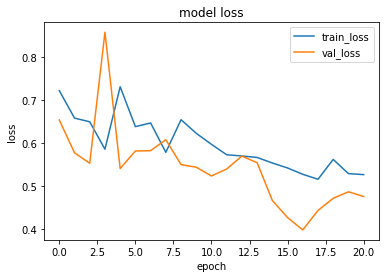

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.52214456]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_3.mov is [[0.5762727]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.55246913]]


1it [00:00, 19972.88it/s]


prediction for video control_1.mov is [[0.37776068]]


1it [00:00, 10407.70it/s]


prediction for video control_2.mov is [[0.36197397]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.36929387]]
Epoch 1/75
3/3 [==============================] - 1s 159ms/step - loss: 0.7889 - accuracy: 0.4125 - precision_4: 0.4314 - recall_4: 0.5500 - val_loss: 0.6672 - val_accuracy: 0.5500 - val_precision_4: 0.5263 - val_recall_4: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6569 - accuracy: 0.6250 - precision_4: 0.6471 - recall_4: 0.5500 - val_loss: 0.6971 - val_accuracy: 0.7000 - val_precision_4: 0.7500 - val_recall_4: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6543 - accuracy: 0.6750 - precision_4: 0.7500 - recall_4: 0.5250 - val_loss: 0.6537 - val_accuracy: 0.7500 - val_precision_4: 0.6923 - val_recall_4: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6197 - accuracy: 0.7250 - precision_4: 0.7045 - recall_4: 0.7750 - val_loss: 0.6688 - val_accuracy: 0.6500 - val_precision_4: 0.6667 - val_recall_4: 0.6000
Epoch 5/75
3/3 [===========

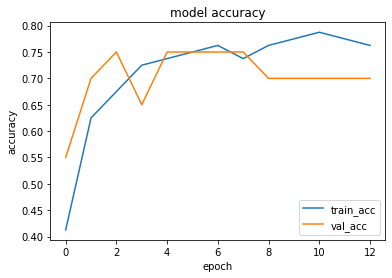

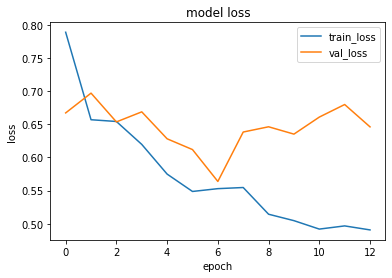

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5373284]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_3.mov is [[0.46747577]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.6106343]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.4244263]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.27217475]]


1it [00:00, 23301.69it/s]


prediction for video control_3.mov is [[0.31401426]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6954 - accuracy: 0.6375 - precision_5: 0.6774 - recall_5: 0.5250 - val_loss: 0.6416 - val_accuracy: 0.5000 - val_precision_5: 0.5000 - val_recall_5: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7009 - accuracy: 0.6125 - precision_5: 0.5652 - recall_5: 0.9750 - val_loss: 0.6539 - val_accuracy: 0.7500 - val_precision_5: 0.8571 - val_recall_5: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6044 - accuracy: 0.7625 - precision_5: 0.7561 - recall_5: 0.7750 - val_loss: 0.6719 - val_accuracy: 0.7500 - val_precision_5: 1.0000 - val_recall_5: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.5930 - accuracy: 0.7250 - precision_5: 0.7647 - recall_5: 0.6500 - val_loss: 0.6533 - val_accuracy: 0.7000 - val_precision_5: 1.0000 - val_recall_5: 0.4000
Epoch 5/75
3/3 [===========

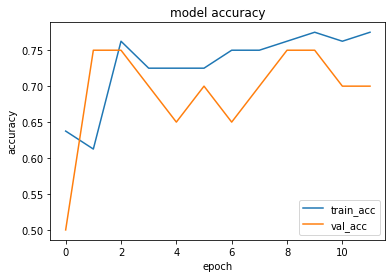

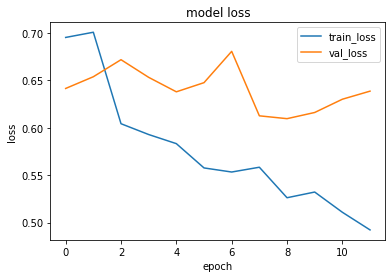

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.5627262]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6671715]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.7057773]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.22834352]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.20211288]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.2039575]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6907 - accuracy: 0.5000 - precision_6: 0.5128 - recall_6: 0.4878 - val_loss: 0.7142 - val_accuracy: 0.6000 - val_precision_6: 0.5333 - val_recall_6: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6405 - accuracy: 0.6125 - precision_6: 0.5735 - recall_6: 0.9512 - val_loss: 0.6488 - val_accuracy: 0.6500 - val_precision_6: 0.6250 - val_recall_6: 0.5556
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5986 - accuracy: 0.7500 - precision_6: 0.8621 - recall_6: 0.6098 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_6: 0.6667 - val_recall_6: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5274 - accuracy: 0.7750 - precision_6: 0.7949 - recall_6: 0.7561 - val_loss: 0.6961 - val_accuracy: 0.7000 - val_precision_6: 0.6667 - val_recall_6: 0.6667
Epoch 5/75
3/3 [============

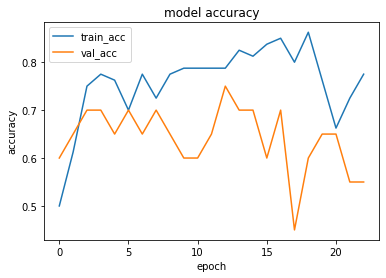

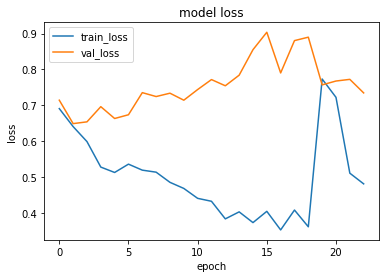

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.3643974]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.35973412]]


1it [00:00, 18315.74it/s]


prediction for video armflapping_2.mov is [[0.71736914]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.2798401]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.21868399]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.25379157]]
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6877 - accuracy: 0.6125 - precision_7: 0.6471 - recall_7: 0.5366 - val_loss: 0.6160 - val_accuracy: 0.7000 - val_precision_7: 0.6364 - val_recall_7: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6319 - accuracy: 0.6625 - precision_7: 0.6250 - recall_7: 0.8537 - val_loss: 0.5903 - val_accuracy: 0.7000 - val_precision_7: 0.6364 - val_recall_7: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6264 - accuracy: 0.6500 - precision_7: 0.6182 - recall_7: 0.8293 - val_loss: 0.5745 - val_accuracy: 0.7500 - val_precision_7: 0.7000 - val_recall_7: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5797 - accuracy: 0.7125 - precision_7: 0.7500 - recall_7: 0.6585 - val_loss: 0.5395 - val_accuracy: 0.7500 - val_precision_7: 0.7000 - val_recall_7: 0.7778
Epoch 5/75
3/3 [===========

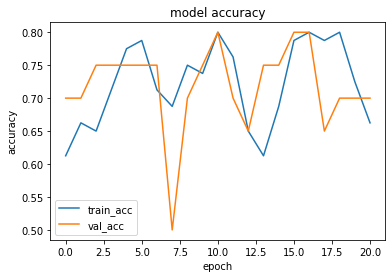

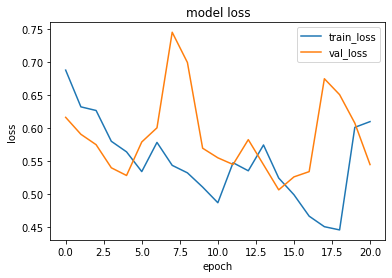

1it [00:00, 12633.45it/s]


prediction for video armflapping_1.mov is [[0.3710574]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.6360263]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_2.mov is [[0.5250546]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.28467762]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.260536]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.25589162]]


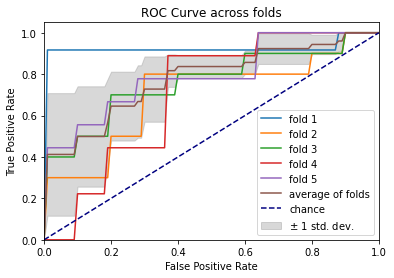

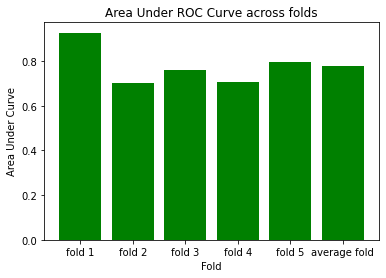

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 170ms/step - loss: 0.6704 - accuracy: 0.5750 - precision_9: 0.5641 - recall_9: 0.5641 - val_loss: 0.8006 - val_accuracy: 0.4500 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 170ms/step - loss: 0.6885 - accuracy: 0.6125 - precision_9: 0.6429 - recall_9: 0.4615 - val_loss: 0.6624 - val_accuracy: 0.7000 - val_precision_9: 0.6923 - val_recall_9: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6249 - accuracy: 0.7500 - precision_9: 0.7111 - recall_9: 0.8205 - val_loss: 0.6758 - val_accuracy: 0.6000 - val_precision_9: 0.6667 - val_recall_9: 0.5455
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6091 - accuracy: 0.7250 - precision_9: 0.7297 - recall_9: 0.6923 - val_loss: 0.6610 - val_accuracy: 0.6500 - val_precision_9: 0.7000 - val_recall_9: 0.6364
Epoch 5/75
3/3 [==============================] - 0s 162ms/step - loss: 

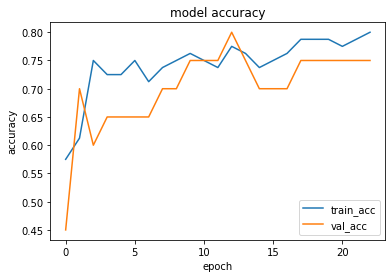

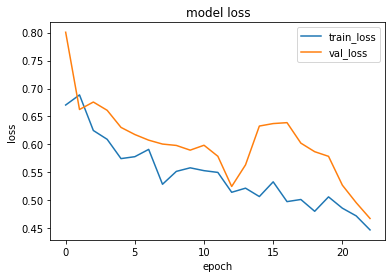

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.484956]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.6554377]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.76726997]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.33138108]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.2596159]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.25511715]]
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6861 - accuracy: 0.5625 - precision_10: 0.5714 - recall_10: 0.6667 - val_loss: 0.6656 - val_accuracy: 0.7500 - val_precision_10: 0.6364 - val_recall_10: 0.8750
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6389 - accuracy: 0.7000 - precision_10: 0.7500 - recall_10: 0.6429 - val_loss: 0.7958 - val_accuracy: 0.4500 - val_precision_10: 0.4000 - val_recall_10: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6599 - accuracy: 0.6500 - precision_10: 0.6296 - recall_10: 0.8095 - val_loss: 0.6513 - val_accuracy: 0.6500 - val_precision_10: 0.5455 - val_recall_10: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.5868 - accuracy: 0.7500 - precision_10: 0.7500 - recall_10: 0.7857 - val_loss: 0.6316 - val_accuracy: 0.7000 - val_precision_10: 0.6000 - val_recall_10: 0.7500
Epoch 5/75


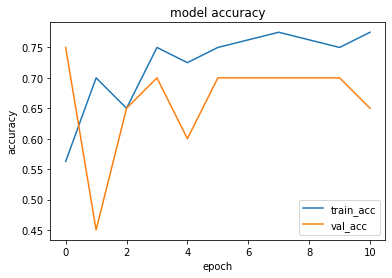

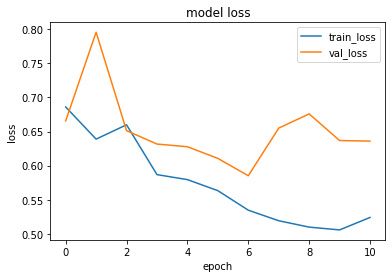

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.52574164]]


1it [00:00, 21732.15it/s]


prediction for video armflapping_3.mov is [[0.7473787]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.7663621]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.34859946]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.21202406]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.2302346]]
Epoch 1/75
3/3 [==============================] - 1s 160ms/step - loss: 0.7338 - accuracy: 0.3875 - precision_11: 0.4310 - recall_11: 0.6098 - val_loss: 0.6705 - val_accuracy: 0.5500 - val_precision_11: 0.5000 - val_recall_11: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6802 - accuracy: 0.5750 - precision_11: 0.5814 - recall_11: 0.6098 - val_loss: 0.6559 - val_accuracy: 0.5000 - val_precision_11: 0.4706 - val_recall_11: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6415 - accuracy: 0.5875 - precision_11: 0.5571 - recall_11: 0.9512 - val_loss: 0.6533 - val_accuracy: 0.5000 - val_precision_11: 0.4706 - val_recall_11: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6073 - accuracy: 0.6250 - precision_11: 0.5846 - recall_11: 0.9268 - val_loss: 0.6518 - val_accuracy: 0.7500 - val_precision_11: 0.6667 - val_recall_11: 0.8889
Epoch 5/75
3

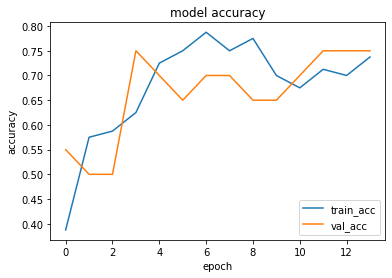

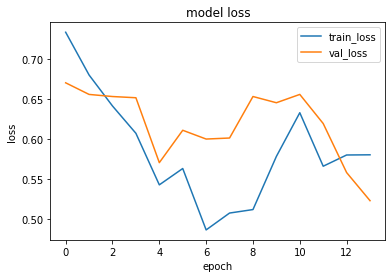

1it [00:00, 12300.01it/s]


prediction for video armflapping_1.mov is [[0.47662407]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.57989126]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.6970042]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.35110193]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.34165376]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.33914673]]
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6647 - accuracy: 0.7000 - precision_12: 0.6596 - recall_12: 0.7949 - val_loss: 0.7052 - val_accuracy: 0.4500 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6368 - accuracy: 0.6500 - precision_12: 0.6774 - recall_12: 0.5385 - val_loss: 0.5943 - val_accuracy: 0.6000 - val_precision_12: 0.6154 - val_recall_12: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.5675 - accuracy: 0.7250 - precision_12: 0.6809 - recall_12: 0.8205 - val_loss: 0.7051 - val_accuracy: 0.7500 - val_precision_12: 0.8000 - val_recall_12: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 167ms/step - loss: 0.5896 - accuracy: 0.6875 - precision_12: 0.6842 - recall_12: 0.6667 - val_loss: 0.7120 - val_accuracy: 0.7000 - val_precision_12: 0.7273 - val_recall_12: 0.7273
Epo

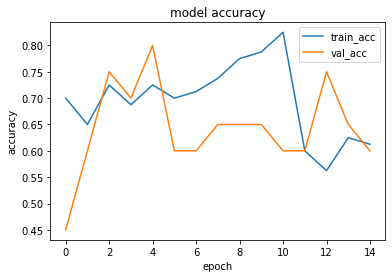

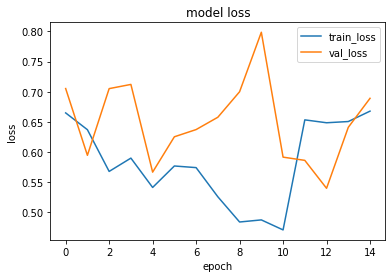

1it [00:00, 11096.04it/s]


prediction for video armflapping_1.mov is [[0.32207167]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.40551615]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.36056882]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.3126992]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.31017327]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.31009483]]
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.7107 - accuracy: 0.4000 - precision_13: 0.3953 - recall_13: 0.4359 - val_loss: 0.6390 - val_accuracy: 0.5500 - val_precision_13: 0.5714 - val_recall_13: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6822 - accuracy: 0.5000 - precision_13: 0.4925 - recall_13: 0.8462 - val_loss: 0.5906 - val_accuracy: 0.7000 - val_precision_13: 0.6923 - val_recall_13: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6275 - accuracy: 0.7375 - precision_13: 0.6875 - recall_13: 0.8462 - val_loss: 0.5667 - val_accuracy: 0.7500 - val_precision_13: 0.7500 - val_recall_13: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.5965 - accuracy: 0.7125 - precision_13: 0.7105 - recall_13: 0.6923 - val_loss: 0.5523 - val_accuracy: 0.8000 - val_precision_13: 0.8182 - val_recall_13: 0.8182
Epoch 5/75


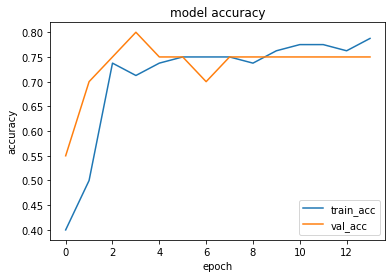

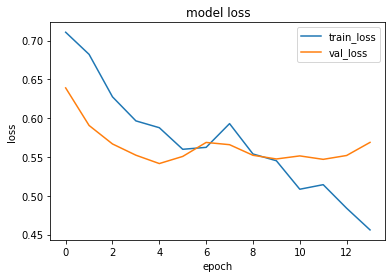

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.53668565]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.6607076]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.7074023]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.41854125]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.29634398]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.31231427]]


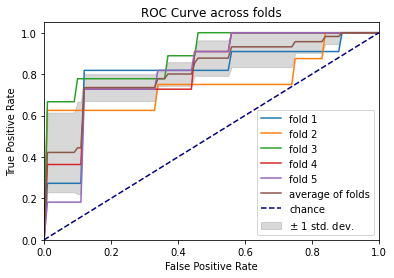

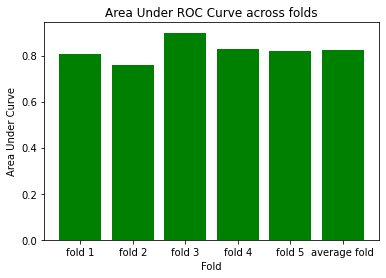

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 191ms/step - loss: 0.6633 - accuracy: 0.5500 - precision_15: 0.5306 - recall_15: 0.6667 - val_loss: 0.6793 - val_accuracy: 0.7000 - val_precision_15: 0.6923 - val_recall_15: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6242 - accuracy: 0.6750 - precision_15: 0.6857 - recall_15: 0.6154 - val_loss: 0.6519 - val_accuracy: 0.5500 - val_precision_15: 0.7500 - val_recall_15: 0.2727
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6030 - accuracy: 0.6875 - precision_15: 0.7188 - recall_15: 0.5897 - val_loss: 0.6661 - val_accuracy: 0.7000 - val_precision_15: 0.7273 - val_recall_15: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5986 - accuracy: 0.7125 - precision_15: 0.6818 - recall_15: 0.7692 - val_loss: 0.5670 - val_accuracy: 0.7500 - val_precision_15: 0.7500 - val_recall_15: 0.8182
Epoch 5/75
3/3 [==============================] - 0s 158ms/step 

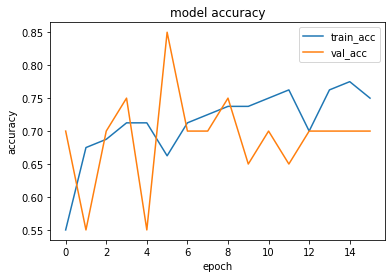

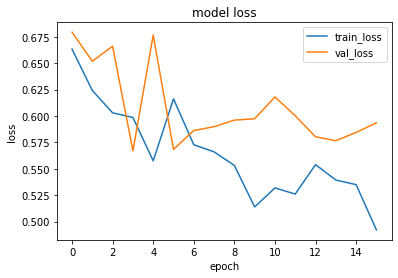

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.4218658]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.46994698]]


1it [00:00, 18641.35it/s]


prediction for video armflapping_2.mov is [[0.5975095]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.34506202]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.30434275]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.30064362]]
Epoch 1/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6968 - accuracy: 0.5375 - precision_16: 0.5676 - recall_16: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.6000 - val_precision_16: 0.5000 - val_recall_16: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6273 - accuracy: 0.7000 - precision_16: 0.6667 - recall_16: 0.8571 - val_loss: 0.7681 - val_accuracy: 0.4500 - val_precision_16: 0.4000 - val_recall_16: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.5878 - accuracy: 0.6625 - precision_16: 0.6415 - recall_16: 0.8095 - val_loss: 0.6496 - val_accuracy: 0.7000 - val_precision_16: 0.6667 - val_recall_16: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.5823 - accuracy: 0.7125 - precision_16: 0.7568 - recall_16: 0.6667 - val_loss: 0.6363 - val_accuracy: 0.6000 - val_precision_16: 0.5000 - val_recall_16: 0.7500
Epoch 5/75


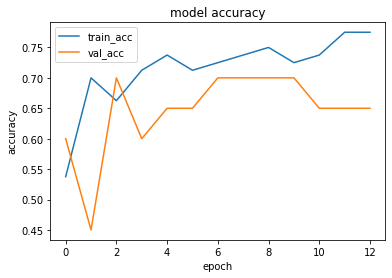

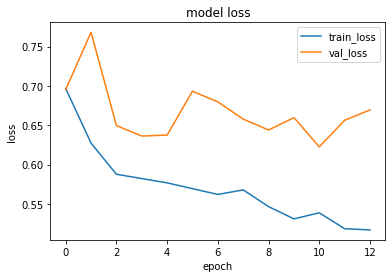

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.5435828]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.6164586]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.65169007]]


1it [00:00, 17331.83it/s]


prediction for video control_1.mov is [[0.48227647]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.4361346]]


1it [00:00, 12300.01it/s]


prediction for video control_3.mov is [[0.44249678]]
Epoch 1/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6775 - accuracy: 0.6125 - precision_17: 0.6667 - recall_17: 0.4878 - val_loss: 0.7911 - val_accuracy: 0.6000 - val_precision_17: 0.5294 - val_recall_17: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 170ms/step - loss: 0.7232 - accuracy: 0.5875 - precision_17: 0.5714 - recall_17: 0.7805 - val_loss: 0.6291 - val_accuracy: 0.7500 - val_precision_17: 0.7500 - val_recall_17: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 183ms/step - loss: 0.6389 - accuracy: 0.7500 - precision_17: 0.8621 - recall_17: 0.6098 - val_loss: 0.6326 - val_accuracy: 0.7500 - val_precision_17: 0.7000 - val_recall_17: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 182ms/step - loss: 0.5979 - accuracy: 0.7375 - precision_17: 0.7632 - recall_17: 0.7073 - val_loss: 0.6405 - val_accuracy: 0.7000 - val_precision_17: 0.6154 - val_recall_17: 0.8889
Epoch 5/75


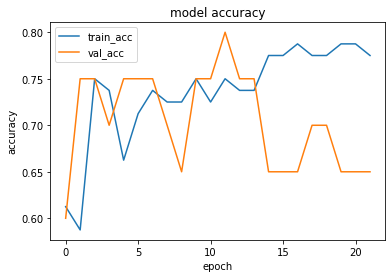

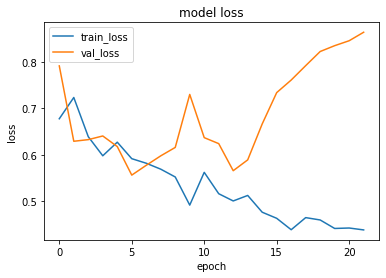

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.38400048]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.6612214]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.7075561]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.3378586]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.3318504]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.33238086]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7035 - accuracy: 0.4750 - precision_18: 0.4737 - recall_18: 0.6923 - val_loss: 0.6184 - val_accuracy: 0.6000 - val_precision_18: 0.5882 - val_recall_18: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6729 - accuracy: 0.6125 - precision_18: 0.5625 - recall_18: 0.9231 - val_loss: 0.6226 - val_accuracy: 0.7500 - val_precision_18: 0.8750 - val_recall_18: 0.6364
Epoch 3/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6473 - accuracy: 0.6625 - precision_18: 0.6500 - recall_18: 0.6667 - val_loss: 0.6464 - val_accuracy: 0.6000 - val_precision_18: 0.8000 - val_recall_18: 0.3636
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6097 - accuracy: 0.6750 - precision_18: 0.6970 - recall_18: 0.5897 - val_loss: 0.6421 - val_accuracy: 0.6500 - val_precision_18: 0.8333 - val_recall_18: 0.4545
Epoch 5/75


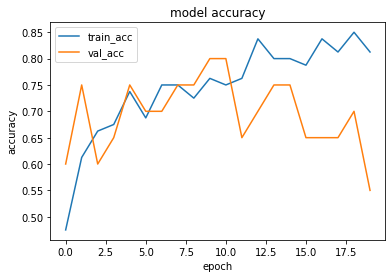

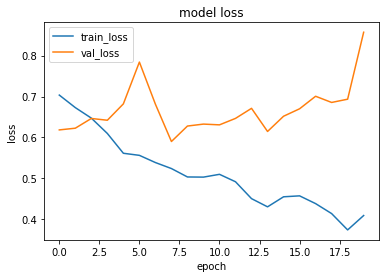

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.27121603]]


1it [00:00, 20460.02it/s]


prediction for video armflapping_3.mov is [[0.6691391]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.7649106]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.23778129]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.23334694]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.22774881]]
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.8031 - accuracy: 0.3875 - precision_19: 0.2917 - recall_19: 0.1795 - val_loss: 0.6730 - val_accuracy: 0.6500 - val_precision_19: 0.6667 - val_recall_19: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6918 - accuracy: 0.5875 - precision_19: 0.5484 - recall_19: 0.8718 - val_loss: 0.6429 - val_accuracy: 0.6000 - val_precision_19: 0.6000 - val_recall_19: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6732 - accuracy: 0.6375 - precision_19: 0.5833 - recall_19: 0.8974 - val_loss: 0.6237 - val_accuracy: 0.7500 - val_precision_19: 0.7500 - val_recall_19: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6390 - accuracy: 0.6875 - precision_19: 0.6522 - recall_19: 0.7692 - val_loss: 0.5844 - val_accuracy: 0.7500 - val_precision_19: 0.7500 - val_recall_19: 0.8182
Epoch 5/75


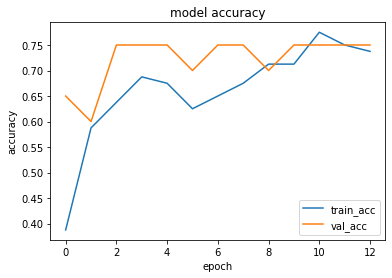

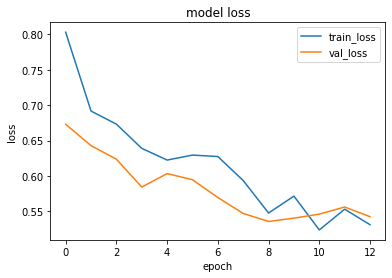

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.5238712]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.3731147]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.56325746]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.41004705]]


1it [00:00, 12372.58it/s]


prediction for video control_2.mov is [[0.29398906]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.30614018]]


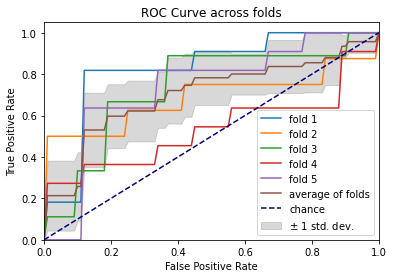

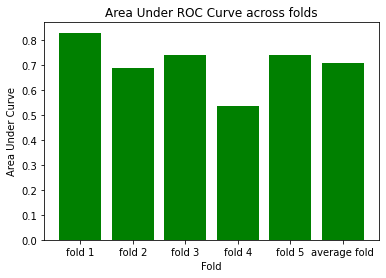

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6961 - accuracy: 0.4500 - precision_21: 0.4615 - recall_21: 0.7692 - val_loss: 0.6787 - val_accuracy: 0.6500 - val_precision_21: 1.0000 - val_recall_21: 0.3636
Epoch 2/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6571 - accuracy: 0.6500 - precision_21: 0.6774 - recall_21: 0.5385 - val_loss: 0.6926 - val_accuracy: 0.7000 - val_precision_21: 0.7273 - val_recall_21: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6325 - accuracy: 0.7250 - precision_21: 0.6889 - recall_21: 0.7949 - val_loss: 0.6874 - val_accuracy: 0.6000 - val_precision_21: 0.6667 - val_recall_21: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 152ms/step - loss: 0.5885 - accuracy: 0.6875 - precision_21: 0.7188 - recall_21: 0.5897 - val_loss: 0.6112 - val_accuracy: 0.6000 - val_precision_21: 0.6667 - val_recall_21: 0.5455
Epoch 5/75
3/3 [==============================] - 0s 162ms/step 

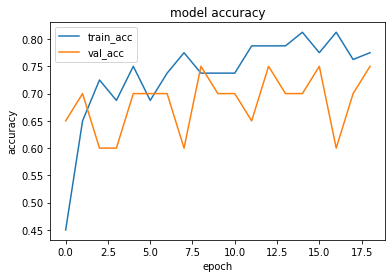

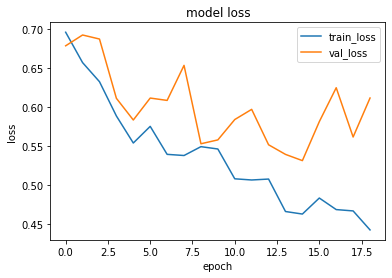

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.46623385]]


1it [00:00, 19972.88it/s]


prediction for video armflapping_3.mov is [[0.47794747]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.64993423]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.28122547]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.20562333]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.2015352]]
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6584 - accuracy: 0.5500 - precision_22: 0.5469 - recall_22: 0.8333 - val_loss: 0.7231 - val_accuracy: 0.4500 - val_precision_22: 0.3846 - val_recall_22: 0.6250
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6304 - accuracy: 0.6125 - precision_22: 0.5965 - recall_22: 0.8095 - val_loss: 0.7701 - val_accuracy: 0.4500 - val_precision_22: 0.4211 - val_recall_22: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6375 - accuracy: 0.6000 - precision_22: 0.5758 - recall_22: 0.9048 - val_loss: 0.6922 - val_accuracy: 0.6000 - val_precision_22: 0.5000 - val_recall_22: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.5947 - accuracy: 0.7125 - precision_22: 0.7111 - recall_22: 0.7619 - val_loss: 0.6668 - val_accuracy: 0.6500 - val_precision_22: 0.5455 - val_recall_22: 0.7500
Epoch 5/75
3

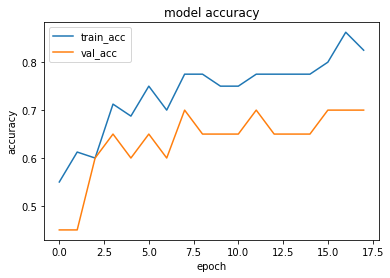

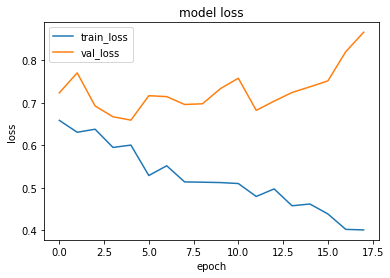

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.3968378]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6825306]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.6725007]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.2675137]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.2092059]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.21530393]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7752 - accuracy: 0.4500 - precision_23: 0.4737 - recall_23: 0.6585 - val_loss: 0.6677 - val_accuracy: 0.8000 - val_precision_23: 0.6923 - val_recall_23: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6822 - accuracy: 0.6125 - precision_23: 0.6923 - recall_23: 0.4390 - val_loss: 0.6737 - val_accuracy: 0.6500 - val_precision_23: 1.0000 - val_recall_23: 0.2222
Epoch 3/75
3/3 [==============================] - 0s 173ms/step - loss: 0.6833 - accuracy: 0.5250 - precision_23: 0.5600 - recall_23: 0.3415 - val_loss: 0.6571 - val_accuracy: 0.8000 - val_precision_23: 0.7778 - val_recall_23: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6614 - accuracy: 0.5375 - precision_23: 0.5435 - recall_23: 0.6098 - val_loss: 0.6388 - val_accuracy: 0.7500 - val_precision_23: 0.6667 - val_recall_23: 0.8889
Epoch 5/75


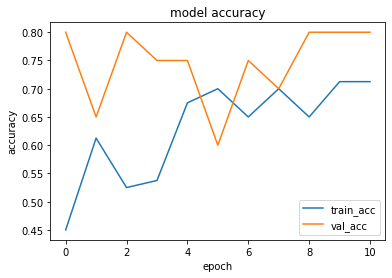

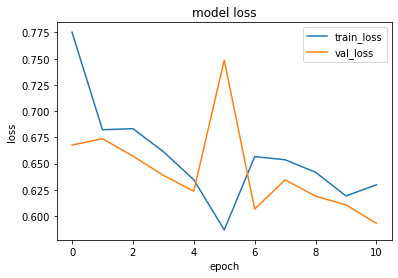

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.5026684]]


1it [00:00, 19878.22it/s]


prediction for video armflapping_3.mov is [[0.5211228]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.5023674]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.4976968]]


1it [00:00, 19691.57it/s]


prediction for video control_2.mov is [[0.4967947]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.497191]]
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7673 - accuracy: 0.3250 - precision_24: 0.2414 - recall_24: 0.1795 - val_loss: 0.6697 - val_accuracy: 0.8000 - val_precision_24: 0.8889 - val_recall_24: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6711 - accuracy: 0.6750 - precision_24: 0.6327 - recall_24: 0.7949 - val_loss: 0.6135 - val_accuracy: 0.6000 - val_precision_24: 0.6154 - val_recall_24: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6322 - accuracy: 0.6875 - precision_24: 0.6250 - recall_24: 0.8974 - val_loss: 0.6358 - val_accuracy: 0.6500 - val_precision_24: 0.8333 - val_recall_24: 0.4545
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6111 - accuracy: 0.7250 - precision_24: 0.8400 - recall_24: 0.5385 - val_loss: 0.6344 - val_accuracy: 0.6500 - val_precision_24: 0.8333 - val_recall_24: 0.4545
Epoch 5/75
3/

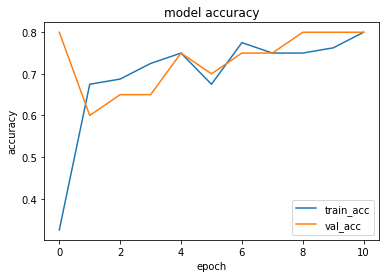

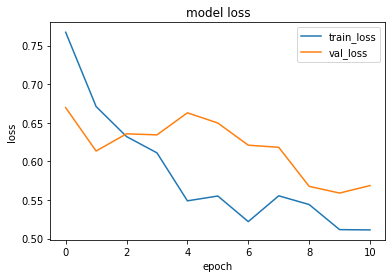

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.5574402]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.72079676]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.69404113]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.45387745]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.41094702]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.39018667]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.7219 - accuracy: 0.4125 - precision_25: 0.3667 - recall_25: 0.2821 - val_loss: 0.6375 - val_accuracy: 0.7000 - val_precision_25: 0.6923 - val_recall_25: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6721 - accuracy: 0.7000 - precision_25: 0.7143 - recall_25: 0.6410 - val_loss: 0.5855 - val_accuracy: 0.7500 - val_precision_25: 0.7143 - val_recall_25: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6462 - accuracy: 0.5750 - precision_25: 0.5410 - recall_25: 0.8462 - val_loss: 0.5744 - val_accuracy: 0.7000 - val_precision_25: 0.6923 - val_recall_25: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6151 - accuracy: 0.7250 - precision_25: 0.7073 - recall_25: 0.7436 - val_loss: 0.5693 - val_accuracy: 0.7500 - val_precision_25: 0.7500 - val_recall_25: 0.8182
Epoch 5/75


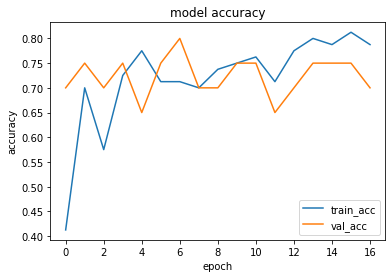

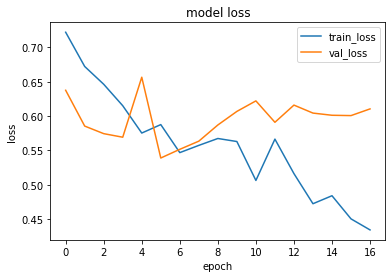

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.5843719]]


1it [00:00, 20360.70it/s]


prediction for video armflapping_3.mov is [[0.7757049]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.7834144]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.28721786]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.18126208]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.16179585]]


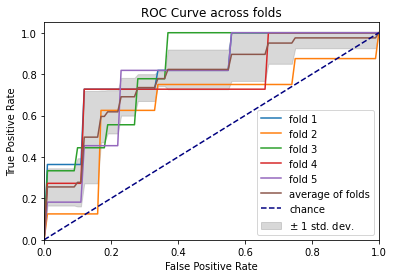

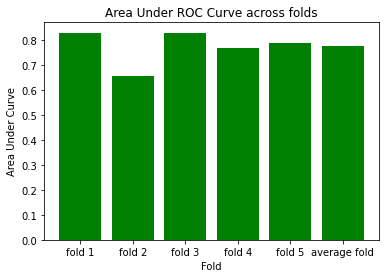

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6869 - accuracy: 0.4750 - precision_27: 0.4737 - recall_27: 0.6923 - val_loss: 0.6613 - val_accuracy: 0.6000 - val_precision_27: 1.0000 - val_recall_27: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 185ms/step - loss: 0.6448 - accuracy: 0.6625 - precision_27: 0.7727 - recall_27: 0.4359 - val_loss: 0.6389 - val_accuracy: 0.7500 - val_precision_27: 0.7500 - val_recall_27: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6119 - accuracy: 0.7250 - precision_27: 0.6889 - recall_27: 0.7949 - val_loss: 0.6713 - val_accuracy: 0.7500 - val_precision_27: 0.7143 - val_recall_27: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6185 - accuracy: 0.7000 - precision_27: 0.6531 - recall_27: 0.8205 - val_loss: 0.6065 - val_accuracy: 0.7500 - val_precision_27: 0.8000 - val_recall_27: 0.7273
Epoch 5/75
3/3 [==============================] - 0s 177ms/step 

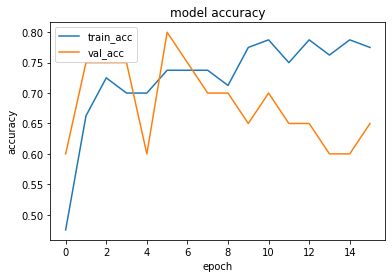

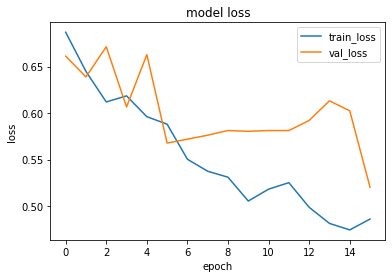

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.4704226]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_3.mov is [[0.52651286]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_2.mov is [[0.6060193]]


1it [00:00, 20068.44it/s]


prediction for video control_1.mov is [[0.3860995]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.34669685]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.33137366]]
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6679 - accuracy: 0.5875 - precision_28: 0.6364 - recall_28: 0.5000 - val_loss: 0.7461 - val_accuracy: 0.5000 - val_precision_28: 0.4444 - val_recall_28: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6155 - accuracy: 0.6125 - precision_28: 0.5797 - recall_28: 0.9524 - val_loss: 0.6537 - val_accuracy: 0.7500 - val_precision_28: 0.6364 - val_recall_28: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5817 - accuracy: 0.7375 - precision_28: 0.7234 - recall_28: 0.8095 - val_loss: 0.6624 - val_accuracy: 0.6000 - val_precision_28: 0.5000 - val_recall_28: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.5862 - accuracy: 0.7500 - precision_28: 0.7500 - recall_28: 0.7857 - val_loss: 0.5883 - val_accuracy: 0.7000 - val_precision_28: 0.6000 - val_recall_28: 0.7500
Epoch 5/75


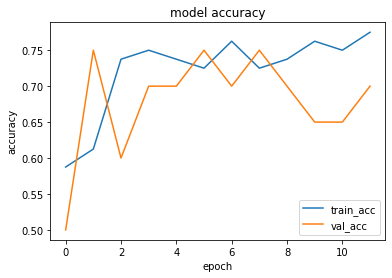

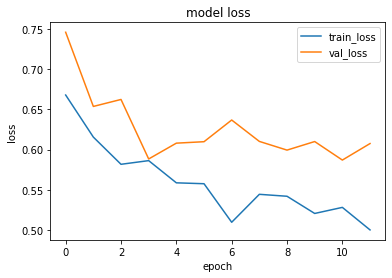

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.5411552]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.69583887]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.77902734]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.28750712]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.21223384]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.1955918]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7033 - accuracy: 0.4625 - precision_29: 0.4815 - recall_29: 0.6341 - val_loss: 0.6549 - val_accuracy: 0.6000 - val_precision_29: 0.5333 - val_recall_29: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6559 - accuracy: 0.6125 - precision_29: 0.5862 - recall_29: 0.8293 - val_loss: 0.6399 - val_accuracy: 0.6500 - val_precision_29: 0.5625 - val_recall_29: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6164 - accuracy: 0.6250 - precision_29: 0.5965 - recall_29: 0.8293 - val_loss: 0.5816 - val_accuracy: 0.7500 - val_precision_29: 0.6429 - val_recall_29: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5817 - accuracy: 0.7125 - precision_29: 0.6875 - recall_29: 0.8049 - val_loss: 0.5640 - val_accuracy: 0.7000 - val_precision_29: 0.6667 - val_recall_29: 0.6667
Epoch 5/75
3

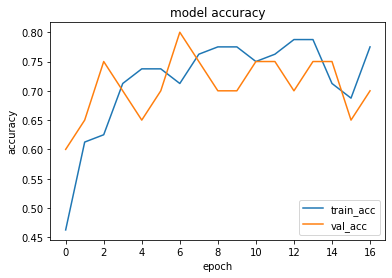

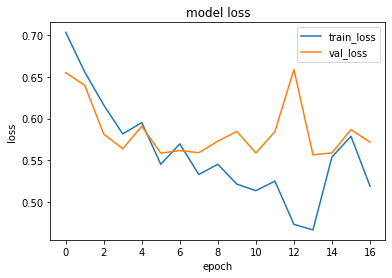

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.32493854]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.86327475]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_2.mov is [[0.723201]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.3100724]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.30659556]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.3083564]]
Epoch 1/75
3/3 [==============================] - 0s 178ms/step - loss: 0.6807 - accuracy: 0.5625 - precision_30: 0.5385 - recall_30: 0.7179 - val_loss: 0.6946 - val_accuracy: 0.4500 - val_precision_30: 0.5000 - val_recall_30: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6686 - accuracy: 0.6500 - precision_30: 0.6486 - recall_30: 0.6154 - val_loss: 0.6058 - val_accuracy: 0.6500 - val_precision_30: 0.6667 - val_recall_30: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5936 - accuracy: 0.7125 - precision_30: 0.6739 - recall_30: 0.7949 - val_loss: 0.6468 - val_accuracy: 0.6000 - val_precision_30: 0.8000 - val_recall_30: 0.3636
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6380 - accuracy: 0.6875 - precision_30: 0.7059 - recall_30: 0.6154 - val_loss: 0.6652 - val_accuracy: 0.5500 - val_precision_30: 0.7500 - val_recall_30: 0.2727
Epoch 5/75
3

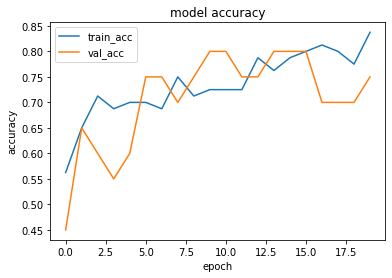

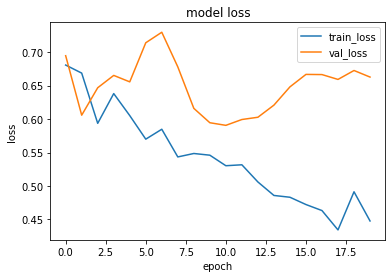

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.5268267]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.7505624]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.60465246]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.09377614]]


1it [00:00, 11244.78it/s]


prediction for video control_2.mov is [[0.08947748]]


1it [00:00, 14979.66it/s]


prediction for video control_3.mov is [[0.09244055]]
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6916 - accuracy: 0.6375 - precision_31: 0.6923 - recall_31: 0.4615 - val_loss: 0.6006 - val_accuracy: 0.7000 - val_precision_31: 0.6923 - val_recall_31: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6697 - accuracy: 0.6750 - precision_31: 0.6585 - recall_31: 0.6923 - val_loss: 0.5745 - val_accuracy: 0.7000 - val_precision_31: 0.6923 - val_recall_31: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6009 - accuracy: 0.6875 - precision_31: 0.6522 - recall_31: 0.7692 - val_loss: 0.5750 - val_accuracy: 0.7000 - val_precision_31: 0.6923 - val_recall_31: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5861 - accuracy: 0.7125 - precision_31: 0.6600 - recall_31: 0.8462 - val_loss: 0.5498 - val_accuracy: 0.7500 - val_precision_31: 0.7500 - val_recall_31: 0.8182
Epoch 5/75


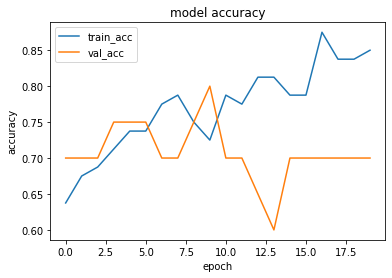

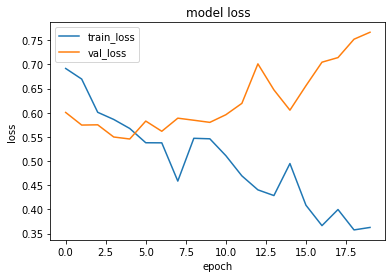

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.8101835]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.92273355]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.8500893]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.47974628]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.29280216]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.2429249]]


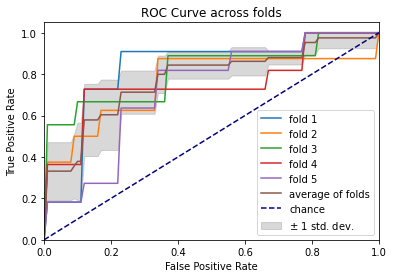

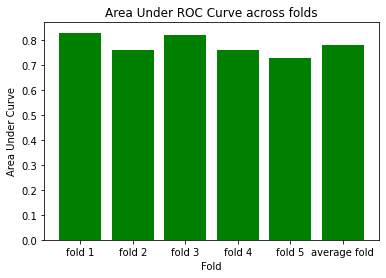

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7060 - accuracy: 0.6000 - precision_33: 0.5814 - recall_33: 0.6410 - val_loss: 0.6784 - val_accuracy: 0.6500 - val_precision_33: 0.8333 - val_recall_33: 0.4545
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6377 - accuracy: 0.7375 - precision_33: 0.7368 - recall_33: 0.7179 - val_loss: 0.6605 - val_accuracy: 0.7500 - val_precision_33: 0.7500 - val_recall_33: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6136 - accuracy: 0.7375 - precision_33: 0.7045 - recall_33: 0.7949 - val_loss: 0.5827 - val_accuracy: 0.8000 - val_precision_33: 0.8889 - val_recall_33: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.5967 - accuracy: 0.7375 - precision_33: 0.7812 - recall_33: 0.6410 - val_loss: 0.6097 - val_accuracy: 0.7000 - val_precision_33: 0.8571 - val_recall_33: 0.5455
Epoch 5/75
3/3 [==============================] - 0s 123ms/step 

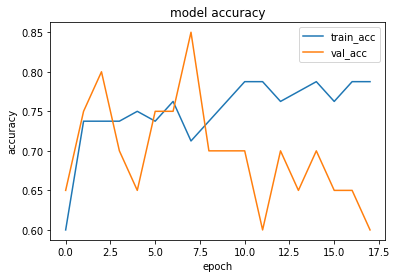

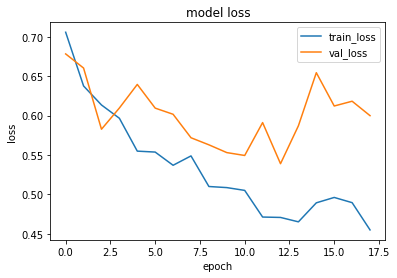

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.43424094]]


1it [00:00, 19691.57it/s]


prediction for video armflapping_3.mov is [[0.55455965]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.6790887]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.32506648]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.27957425]]


1it [00:00, 10538.45it/s]


prediction for video control_3.mov is [[0.26233506]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6964 - accuracy: 0.4750 - precision_34: 0.5000 - recall_34: 0.7143 - val_loss: 0.6798 - val_accuracy: 0.4500 - val_precision_34: 0.4000 - val_recall_34: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 194ms/step - loss: 0.6099 - accuracy: 0.6125 - precision_34: 0.5846 - recall_34: 0.9048 - val_loss: 0.6804 - val_accuracy: 0.6000 - val_precision_34: 0.5000 - val_recall_34: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 0.5916 - accuracy: 0.7000 - precision_34: 0.6731 - recall_34: 0.8333 - val_loss: 0.6585 - val_accuracy: 0.6500 - val_precision_34: 0.5455 - val_recall_34: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.5720 - accuracy: 0.7000 - precision_34: 0.6667 - recall_34: 0.8571 - val_loss: 0.6445 - val_accuracy: 0.7000 - val_precision_34: 0.6000 - val_recall_34: 0.7500
Epoch 5/75


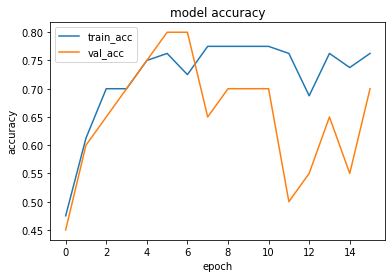

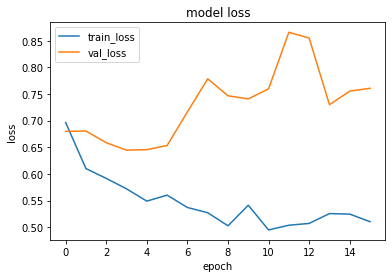

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.63137716]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.80897164]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.8670814]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.4536167]]


1it [00:00, 19508.39it/s]


prediction for video control_2.mov is [[0.35203737]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.34986034]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7001 - accuracy: 0.4875 - precision_35: 0.5000 - recall_35: 0.6341 - val_loss: 0.6580 - val_accuracy: 0.4500 - val_precision_35: 0.4444 - val_recall_35: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6360 - accuracy: 0.6125 - precision_35: 0.5781 - recall_35: 0.9024 - val_loss: 0.7130 - val_accuracy: 0.5000 - val_precision_35: 0.4737 - val_recall_35: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.7124 - accuracy: 0.5625 - precision_35: 0.5417 - recall_35: 0.9512 - val_loss: 0.6368 - val_accuracy: 0.7000 - val_precision_35: 0.6364 - val_recall_35: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6541 - accuracy: 0.6500 - precision_35: 0.6857 - recall_35: 0.5854 - val_loss: 0.6288 - val_accuracy: 0.7000 - val_precision_35: 0.7143 - val_recall_35: 0.5556
Epoch 5/75


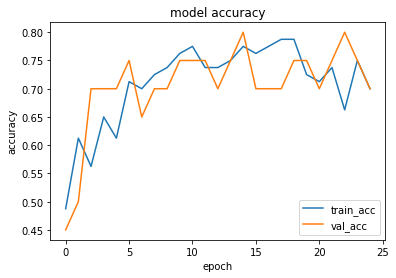

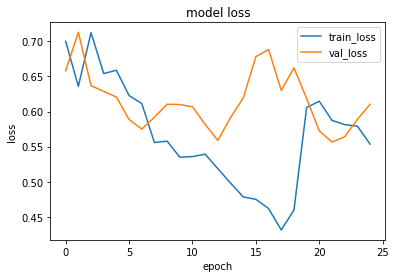

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.42600206]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5125476]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.6866701]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.4051705]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.29513383]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.35771364]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6734 - accuracy: 0.5625 - precision_36: 0.5345 - recall_36: 0.7949 - val_loss: 0.6085 - val_accuracy: 0.6000 - val_precision_36: 0.6154 - val_recall_36: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6590 - accuracy: 0.6250 - precision_36: 0.5882 - recall_36: 0.7692 - val_loss: 0.6252 - val_accuracy: 0.6500 - val_precision_36: 0.8333 - val_recall_36: 0.4545
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6339 - accuracy: 0.6750 - precision_36: 0.8095 - recall_36: 0.4359 - val_loss: 0.6639 - val_accuracy: 0.5500 - val_precision_36: 0.7500 - val_recall_36: 0.2727
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6254 - accuracy: 0.7000 - precision_36: 0.8261 - recall_36: 0.4872 - val_loss: 0.6110 - val_accuracy: 0.6500 - val_precision_36: 0.8333 - val_recall_36: 0.4545
Epoch 5/75


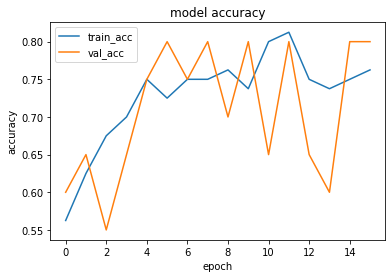

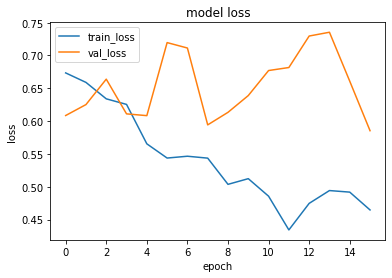

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.49553564]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.63100725]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.6591224]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.31138438]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.2569238]]


1it [00:00, 6615.62it/s]


prediction for video control_3.mov is [[0.20200631]]
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.7352 - accuracy: 0.4875 - precision_37: 0.4286 - recall_37: 0.1538 - val_loss: 0.6502 - val_accuracy: 0.5500 - val_precision_37: 0.5500 - val_recall_37: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7054 - accuracy: 0.5250 - precision_37: 0.5068 - recall_37: 0.9487 - val_loss: 0.6207 - val_accuracy: 0.7000 - val_precision_37: 0.6923 - val_recall_37: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6522 - accuracy: 0.7125 - precision_37: 0.6667 - recall_37: 0.8205 - val_loss: 0.6009 - val_accuracy: 0.7500 - val_precision_37: 0.7500 - val_recall_37: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6274 - accuracy: 0.7250 - precision_37: 0.7073 - recall_37: 0.7436 - val_loss: 0.5715 - val_accuracy: 0.8500 - val_precision_37: 0.9000 - val_recall_37: 0.8182
Epoch 5/75


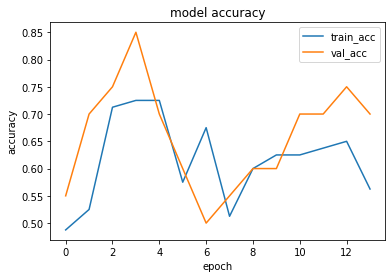

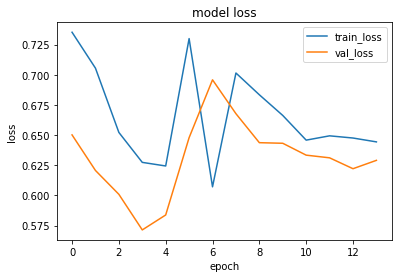

1it [00:00, 14027.77it/s]


prediction for video armflapping_1.mov is [[0.45130923]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.5233095]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.4698364]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.44765645]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.44672984]]


1it [00:00, 19691.57it/s]

prediction for video control_3.mov is [[0.4466798]]


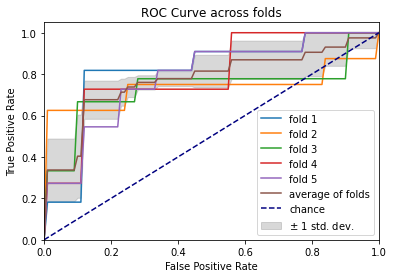

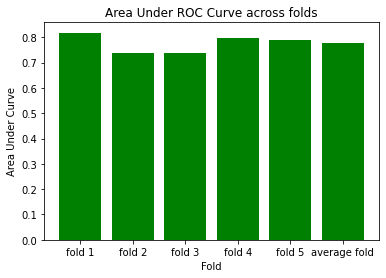

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6647 - accuracy: 0.6375 - precision_39: 0.6667 - recall_39: 0.5128 - val_loss: 0.5807 - val_accuracy: 0.7000 - val_precision_39: 0.6667 - val_recall_39: 0.9091
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6199 - accuracy: 0.7000 - precision_39: 0.6667 - recall_39: 0.7692 - val_loss: 0.6733 - val_accuracy: 0.5000 - val_precision_39: 0.6667 - val_recall_39: 0.1818
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5778 - accuracy: 0.7000 - precision_39: 0.8261 - recall_39: 0.4872 - val_loss: 0.6748 - val_accuracy: 0.7000 - val_precision_39: 0.6923 - val_recall_39: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6524 - accuracy: 0.6750 - precision_39: 0.6275 - recall_39: 0.8205 - val_loss: 0.6544 - val_accuracy: 0.7500 - val_precision_39: 0.7500 - val_recall_39: 0.8182
Epoch 5/75
3/3 [==============================] - 0s 123ms/step 

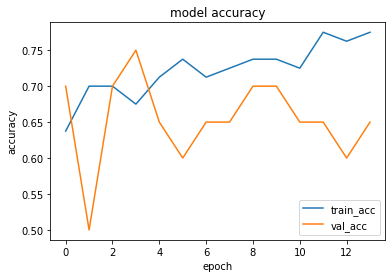

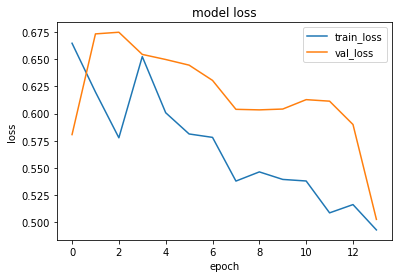

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.5131931]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5215859]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_2.mov is [[0.64739335]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.42067546]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.3162243]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.34220797]]
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6593 - accuracy: 0.5875 - precision_40: 0.5616 - recall_40: 0.9762 - val_loss: 0.6719 - val_accuracy: 0.6500 - val_precision_40: 0.5556 - val_recall_40: 0.6250
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6098 - accuracy: 0.7000 - precision_40: 0.6875 - recall_40: 0.7857 - val_loss: 0.6081 - val_accuracy: 0.6500 - val_precision_40: 0.5556 - val_recall_40: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5535 - accuracy: 0.7750 - precision_40: 0.8000 - recall_40: 0.7619 - val_loss: 0.5855 - val_accuracy: 0.7000 - val_precision_40: 0.6250 - val_recall_40: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6511 - accuracy: 0.7125 - precision_40: 0.7209 - recall_40: 0.7381 - val_loss: 0.6532 - val_accuracy: 0.6000 - val_precision_40: 0.5000 - val_recall_40: 0.7500
Epoch 5/75


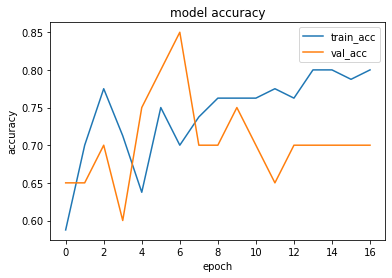

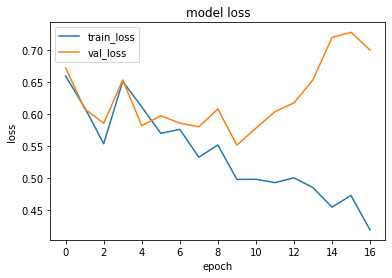

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.49691156]]


1it [00:00, 18724.57it/s]


prediction for video armflapping_3.mov is [[0.5264847]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.54402435]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.4453748]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.40534502]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.40513057]]
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.7011 - accuracy: 0.5125 - precision_41: 0.5152 - recall_41: 0.8293 - val_loss: 0.6612 - val_accuracy: 0.7500 - val_precision_41: 1.0000 - val_recall_41: 0.4444
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6561 - accuracy: 0.5625 - precision_41: 0.5714 - recall_41: 0.5854 - val_loss: 0.6477 - val_accuracy: 0.4500 - val_precision_41: 0.4444 - val_recall_41: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6043 - accuracy: 0.6500 - precision_41: 0.6140 - recall_41: 0.8537 - val_loss: 0.6413 - val_accuracy: 0.7000 - val_precision_41: 0.6154 - val_recall_41: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 162ms/step - loss: 0.5622 - accuracy: 0.7750 - precision_41: 0.7949 - recall_41: 0.7561 - val_loss: 0.5772 - val_accuracy: 0.6500 - val_precision_41: 0.6000 - val_recall_41: 0.6667
Epoch 5/75


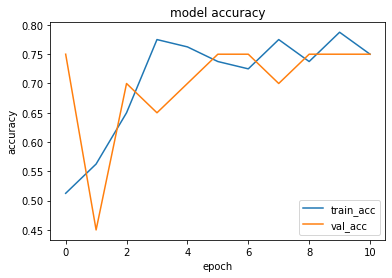

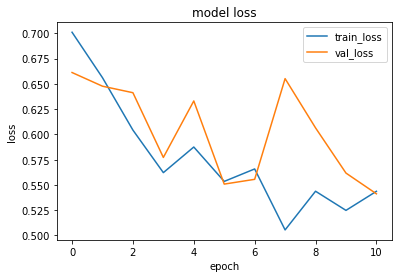

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5403682]]


1it [00:00, 21183.35it/s]


prediction for video armflapping_3.mov is [[0.7162044]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_2.mov is [[0.7464381]]


1it [00:00, 12671.61it/s]


prediction for video control_1.mov is [[0.37020242]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.32402188]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.3317554]]
Epoch 1/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6717 - accuracy: 0.6750 - precision_42: 0.6444 - recall_42: 0.7436 - val_loss: 0.6202 - val_accuracy: 0.6000 - val_precision_42: 0.6154 - val_recall_42: 0.7273
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6020 - accuracy: 0.7375 - precision_42: 0.7045 - recall_42: 0.7949 - val_loss: 0.6134 - val_accuracy: 0.8000 - val_precision_42: 0.8889 - val_recall_42: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5851 - accuracy: 0.7500 - precision_42: 0.7111 - recall_42: 0.8205 - val_loss: 0.8438 - val_accuracy: 0.8000 - val_precision_42: 0.8889 - val_recall_42: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5960 - accuracy: 0.7250 - precision_42: 0.7179 - recall_42: 0.7179 - val_loss: 0.7579 - val_accuracy: 0.7500 - val_precision_42: 0.8750 - val_recall_42: 0.6364
Epoch 5/75
3

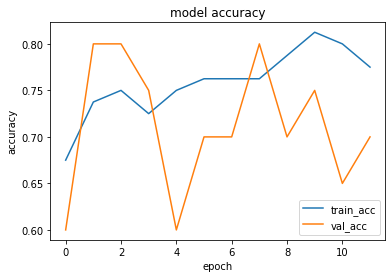

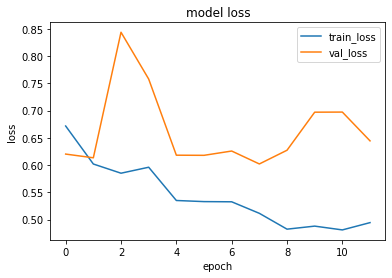

1it [00:00, 6990.51it/s]


prediction for video armflapping_1.mov is [[0.52076316]]


1it [00:00, 20763.88it/s]


prediction for video armflapping_3.mov is [[0.72018045]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.6256844]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.23340738]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.17776474]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.1670168]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7148 - accuracy: 0.5625 - precision_43: 0.5370 - recall_43: 0.7436 - val_loss: 0.6379 - val_accuracy: 0.6500 - val_precision_43: 0.7500 - val_recall_43: 0.5455
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6504 - accuracy: 0.6875 - precision_43: 0.6842 - recall_43: 0.6667 - val_loss: 0.5588 - val_accuracy: 0.7000 - val_precision_43: 0.6923 - val_recall_43: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6451 - accuracy: 0.6625 - precision_43: 0.6500 - recall_43: 0.6667 - val_loss: 0.5601 - val_accuracy: 0.8000 - val_precision_43: 0.8889 - val_recall_43: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5754 - accuracy: 0.7750 - precision_43: 0.7838 - recall_43: 0.7436 - val_loss: 0.5456 - val_accuracy: 0.7000 - val_precision_43: 0.6923 - val_recall_43: 0.8182
Epoch 5/75
3

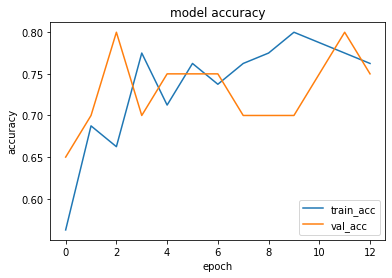

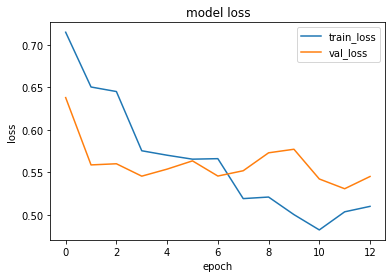

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.40526906]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.55103534]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.64331394]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.3201846]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.281677]]


1it [00:00, 18157.16it/s]

prediction for video control_3.mov is [[0.24994925]]


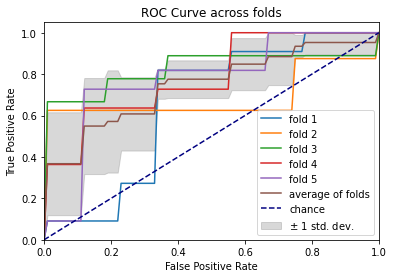

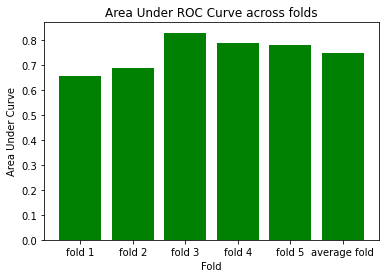

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6877 - accuracy: 0.5625 - precision_45: 0.5435 - recall_45: 0.6410 - val_loss: 0.6576 - val_accuracy: 0.7500 - val_precision_45: 0.7500 - val_recall_45: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6319 - accuracy: 0.7250 - precision_45: 0.7073 - recall_45: 0.7436 - val_loss: 0.6239 - val_accuracy: 0.7500 - val_precision_45: 0.7143 - val_recall_45: 0.9091
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5811 - accuracy: 0.7000 - precision_45: 0.6744 - recall_45: 0.7436 - val_loss: 0.6356 - val_accuracy: 0.7500 - val_precision_45: 0.7500 - val_recall_45: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5767 - accuracy: 0.7375 - precision_45: 0.7143 - recall_45: 0.7692 - val_loss: 0.6428 - val_accuracy: 0.6000 - val_precision_45: 0.7143 - val_recall_45: 0.4545
Epoch 5/75
3/3 [==============================] - 0s 126ms/step 

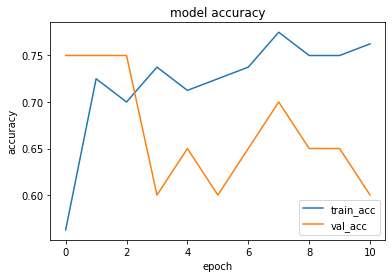

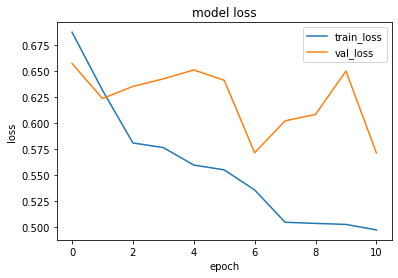

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.5149257]]


1it [00:00, 19508.39it/s]


prediction for video armflapping_3.mov is [[0.51117593]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.5347543]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4967484]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.4879104]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.4864557]]
Epoch 1/75
3/3 [==============================] - 1s 139ms/step - loss: 0.7206 - accuracy: 0.4625 - precision_46: 0.4912 - recall_46: 0.6667 - val_loss: 0.6698 - val_accuracy: 0.6000 - val_precision_46: 0.5000 - val_recall_46: 0.7500
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6392 - accuracy: 0.6750 - precision_46: 0.7500 - recall_46: 0.5714 - val_loss: 0.6676 - val_accuracy: 0.6500 - val_precision_46: 0.5714 - val_recall_46: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6241 - accuracy: 0.7125 - precision_46: 0.7021 - recall_46: 0.7857 - val_loss: 0.6425 - val_accuracy: 0.7500 - val_precision_46: 0.6364 - val_recall_46: 0.8750
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.5812 - accuracy: 0.7125 - precision_46: 0.6939 - recall_46: 0.8095 - val_loss: 0.6194 - val_accuracy: 0.7000 - val_precision_46: 0.6250 - val_recall_46: 0.6250
Epoch 5/75
3

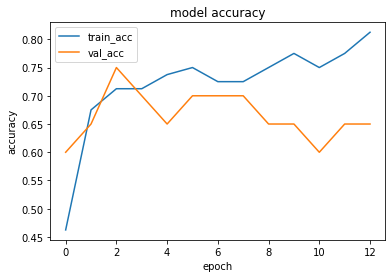

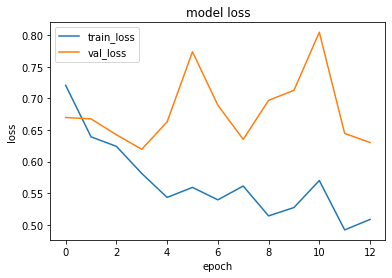

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5403798]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.4477588]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.6685933]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.44865832]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.3835401]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.38596645]]
Epoch 1/75
3/3 [==============================] - 1s 194ms/step - loss: 0.7040 - accuracy: 0.4625 - precision_47: 0.4583 - recall_47: 0.2683 - val_loss: 0.6694 - val_accuracy: 0.4500 - val_precision_47: 0.4500 - val_recall_47: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 179ms/step - loss: 0.6741 - accuracy: 0.5250 - precision_47: 0.5195 - recall_47: 0.9756 - val_loss: 0.6306 - val_accuracy: 0.8000 - val_precision_47: 0.6923 - val_recall_47: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 178ms/step - loss: 0.6388 - accuracy: 0.7250 - precision_47: 0.7209 - recall_47: 0.7561 - val_loss: 0.5940 - val_accuracy: 0.7500 - val_precision_47: 0.7000 - val_recall_47: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 188ms/step - loss: 0.5827 - accuracy: 0.7500 - precision_47: 0.7692 - recall_47: 0.7317 - val_loss: 0.5762 - val_accuracy: 0.7000 - val_precision_47: 0.6364 - val_recall_47: 0.7778
Epoch 5/75


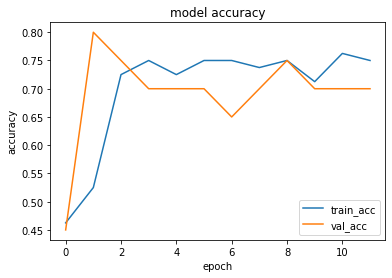

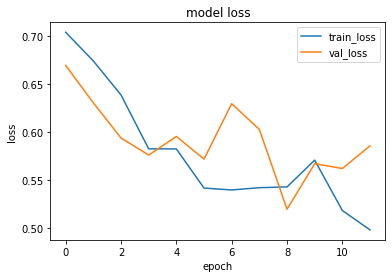

1it [00:00, 13025.79it/s]


prediction for video armflapping_1.mov is [[0.52955085]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.53876483]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_2.mov is [[0.5696896]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.50355804]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.4880362]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.48555708]]
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.7439 - accuracy: 0.5625 - precision_48: 0.5323 - recall_48: 0.8462 - val_loss: 0.6801 - val_accuracy: 0.4500 - val_precision_48: 0.5000 - val_recall_48: 0.0909
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6824 - accuracy: 0.5750 - precision_48: 0.6923 - recall_48: 0.2308 - val_loss: 0.6578 - val_accuracy: 0.6500 - val_precision_48: 0.8333 - val_recall_48: 0.4545
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6422 - accuracy: 0.7000 - precision_48: 0.7027 - recall_48: 0.6667 - val_loss: 0.6065 - val_accuracy: 0.6500 - val_precision_48: 0.6667 - val_recall_48: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6341 - accuracy: 0.6625 - precision_48: 0.6000 - recall_48: 0.9231 - val_loss: 0.6194 - val_accuracy: 0.7500 - val_precision_48: 0.8750 - val_recall_48: 0.6364
Epoch 5/75


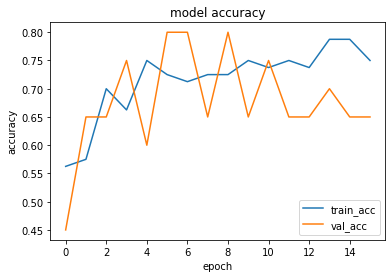

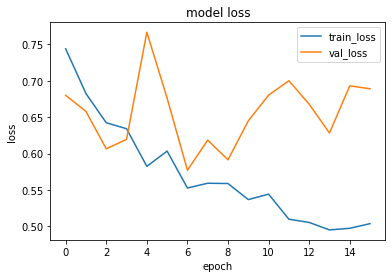

1it [00:00, 19599.55it/s]


prediction for video armflapping_1.mov is [[0.6051184]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.7498254]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.7556994]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.15453944]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.13324213]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.13242951]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6926 - accuracy: 0.5375 - precision_49: 0.5179 - recall_49: 0.7436 - val_loss: 0.6386 - val_accuracy: 0.7000 - val_precision_49: 0.7778 - val_recall_49: 0.6364
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6531 - accuracy: 0.6625 - precision_49: 0.6304 - recall_49: 0.7436 - val_loss: 0.5634 - val_accuracy: 0.7500 - val_precision_49: 0.7500 - val_recall_49: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5912 - accuracy: 0.6875 - precision_49: 0.7059 - recall_49: 0.6154 - val_loss: 0.5606 - val_accuracy: 0.7500 - val_precision_49: 0.8750 - val_recall_49: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6031 - accuracy: 0.7375 - precision_49: 0.7812 - recall_49: 0.6410 - val_loss: 0.5216 - val_accuracy: 0.8000 - val_precision_49: 0.7692 - val_recall_49: 0.9091
Epoch 5/75


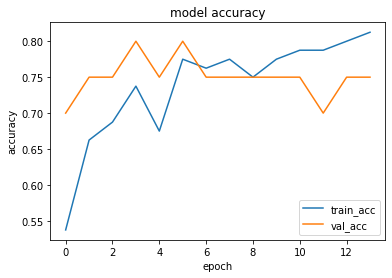

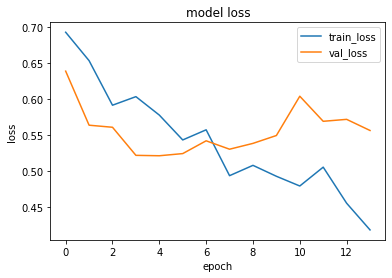

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.68833494]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.83999217]]


1it [00:00, 19508.39it/s]


prediction for video armflapping_2.mov is [[0.78138614]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.46008068]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.287982]]


1it [00:00, 9258.95it/s]


prediction for video control_3.mov is [[0.38080737]]


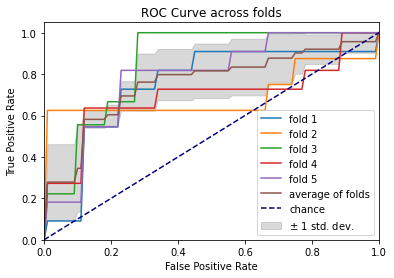

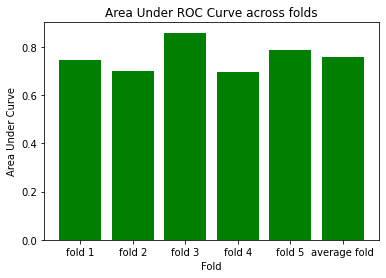

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6736 - accuracy: 0.5875 - precision_51: 0.5938 - recall_51: 0.4872 - val_loss: 0.7158 - val_accuracy: 0.5500 - val_precision_51: 0.5500 - val_recall_51: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6448 - accuracy: 0.6625 - precision_51: 0.6000 - recall_51: 0.9231 - val_loss: 0.6026 - val_accuracy: 0.8000 - val_precision_51: 0.8889 - val_recall_51: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6081 - accuracy: 0.7125 - precision_51: 0.7000 - recall_51: 0.7179 - val_loss: 0.5455 - val_accuracy: 0.8000 - val_precision_51: 0.7692 - val_recall_51: 0.9091
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5614 - accuracy: 0.7000 - precision_51: 0.6531 - recall_51: 0.8205 - val_loss: 0.6248 - val_accuracy: 0.7000 - val_precision_51: 0.6923 - val_recall_51: 0.8182
Epoch 5/75
3/3 [==============================] - 0s 150ms/step 

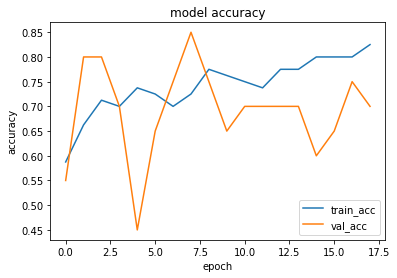

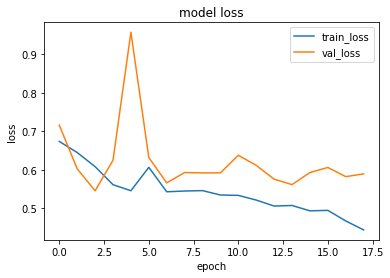

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.45986342]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.43296057]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.56551015]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.31962866]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.30058694]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.2914919]]
Epoch 1/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6701 - accuracy: 0.6000 - precision_52: 0.5758 - recall_52: 0.9048 - val_loss: 0.6652 - val_accuracy: 0.6500 - val_precision_52: 0.5714 - val_recall_52: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6073 - accuracy: 0.6875 - precision_52: 0.7429 - recall_52: 0.6190 - val_loss: 0.6623 - val_accuracy: 0.6000 - val_precision_52: 0.5000 - val_recall_52: 0.7500
Epoch 3/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6712 - accuracy: 0.6750 - precision_52: 0.6481 - recall_52: 0.8333 - val_loss: 0.6874 - val_accuracy: 0.6000 - val_precision_52: 0.5000 - val_recall_52: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.5814 - accuracy: 0.7500 - precision_52: 0.7391 - recall_52: 0.8095 - val_loss: 0.6586 - val_accuracy: 0.7000 - val_precision_52: 0.6667 - val_recall_52: 0.5000
Epoch 5/75
3

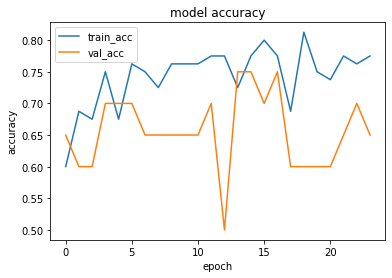

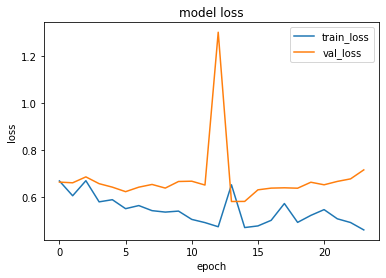

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.44516635]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5839078]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.79652447]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.39651585]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.2267572]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.31046587]]
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.7387 - accuracy: 0.4875 - precision_53: 0.5000 - recall_53: 0.6585 - val_loss: 0.6452 - val_accuracy: 0.4500 - val_precision_53: 0.4444 - val_recall_53: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6553 - accuracy: 0.6500 - precision_53: 0.6667 - recall_53: 0.6341 - val_loss: 0.6497 - val_accuracy: 0.7500 - val_precision_53: 0.7000 - val_recall_53: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6341 - accuracy: 0.7375 - precision_53: 0.7778 - recall_53: 0.6829 - val_loss: 0.6401 - val_accuracy: 0.8000 - val_precision_53: 0.7273 - val_recall_53: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6139 - accuracy: 0.7250 - precision_53: 0.7111 - recall_53: 0.7805 - val_loss: 0.6565 - val_accuracy: 0.7500 - val_precision_53: 0.6667 - val_recall_53: 0.8889
Epoch 5/75


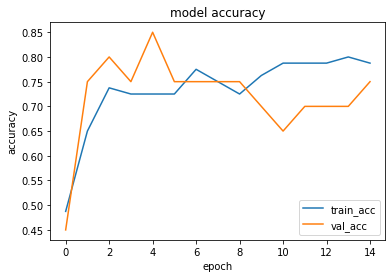

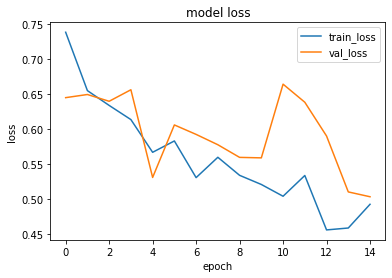

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.37725884]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.3730617]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.6172406]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.35434502]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.35728335]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.36115783]]
Epoch 1/75
3/3 [==============================] - 0s 167ms/step - loss: 0.8154 - accuracy: 0.3500 - precision_54: 0.3934 - recall_54: 0.6154 - val_loss: 0.6878 - val_accuracy: 0.6500 - val_precision_54: 0.7000 - val_recall_54: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6752 - accuracy: 0.7000 - precision_54: 0.6667 - recall_54: 0.7692 - val_loss: 0.6760 - val_accuracy: 0.5000 - val_precision_54: 0.6667 - val_recall_54: 0.1818
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6670 - accuracy: 0.6500 - precision_54: 0.7200 - recall_54: 0.4615 - val_loss: 0.6641 - val_accuracy: 0.5500 - val_precision_54: 0.7500 - val_recall_54: 0.2727
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6220 - accuracy: 0.6500 - precision_54: 0.7200 - recall_54: 0.4615 - val_loss: 0.7069 - val_accuracy: 0.7500 - val_precision_54: 0.8000 - val_recall_54: 0.7273
Epoch 5/75


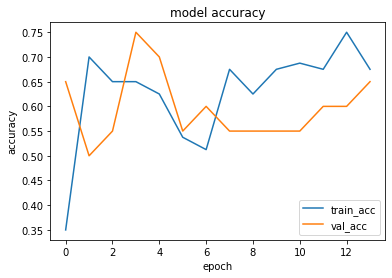

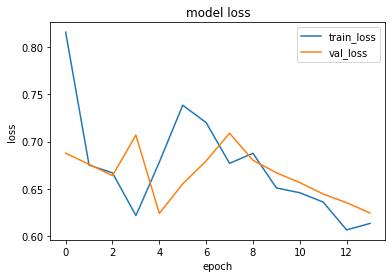

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.4284817]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.33851838]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.49310413]]


1it [00:00, 16194.22it/s]


prediction for video control_1.mov is [[0.38135767]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.36855218]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.36477754]]
Epoch 1/75
3/3 [==============================] - 1s 175ms/step - loss: 0.7251 - accuracy: 0.4625 - precision_55: 0.4500 - recall_55: 0.4615 - val_loss: 0.6271 - val_accuracy: 0.6500 - val_precision_55: 0.6111 - val_recall_55: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 176ms/step - loss: 0.6848 - accuracy: 0.5375 - precision_55: 0.5135 - recall_55: 0.9744 - val_loss: 0.6059 - val_accuracy: 0.7500 - val_precision_55: 0.7500 - val_recall_55: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 197ms/step - loss: 0.6453 - accuracy: 0.7125 - precision_55: 0.7222 - recall_55: 0.6667 - val_loss: 0.6185 - val_accuracy: 0.6500 - val_precision_55: 0.7500 - val_recall_55: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 203ms/step - loss: 0.6231 - accuracy: 0.7500 - precision_55: 0.7879 - recall_55: 0.6667 - val_loss: 0.5489 - val_accuracy: 0.7000 - val_precision_55: 0.6923 - val_recall_55: 0.8182
Epoch 5/75


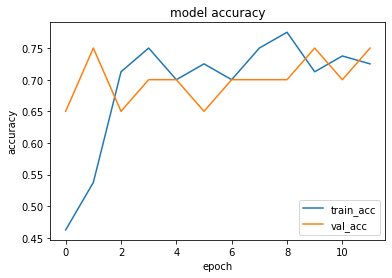

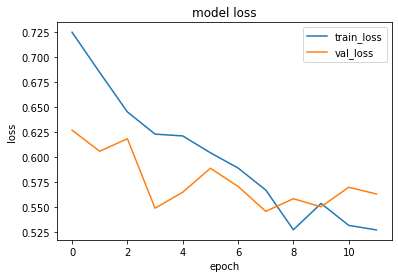

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4795388]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.46102163]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.59304106]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.29033446]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.2364257]]


1it [00:00, 16578.28it/s]


prediction for video control_3.mov is [[0.202862]]


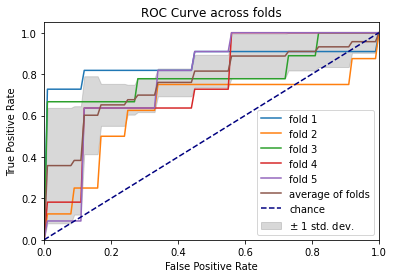

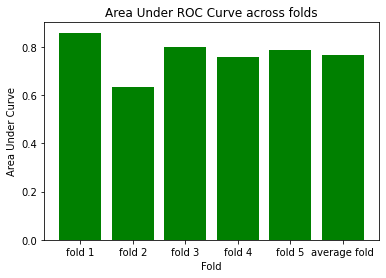

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 166ms/step - loss: 0.7723 - accuracy: 0.4375 - precision_57: 0.3929 - recall_57: 0.2821 - val_loss: 0.6950 - val_accuracy: 0.5500 - val_precision_57: 0.5500 - val_recall_57: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6748 - accuracy: 0.5375 - precision_57: 0.5132 - recall_57: 1.0000 - val_loss: 0.6837 - val_accuracy: 0.5500 - val_precision_57: 0.5500 - val_recall_57: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6436 - accuracy: 0.6125 - precision_57: 0.5625 - recall_57: 0.9231 - val_loss: 0.6880 - val_accuracy: 0.6500 - val_precision_57: 0.7000 - val_recall_57: 0.6364
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6629 - accuracy: 0.6375 - precision_57: 0.7083 - recall_57: 0.4359 - val_loss: 0.6910 - val_accuracy: 0.5000 - val_precision_57: 0.6000 - val_recall_57: 0.2727
Epoch 5/75
3/3 [==============================] - 0s 151ms/step 

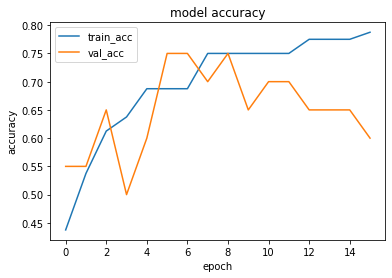

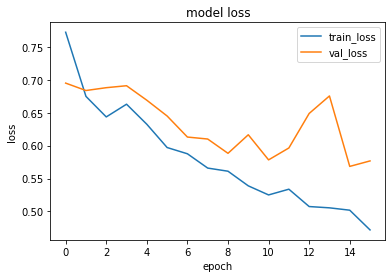

1it [00:00, 17623.13it/s]


prediction for video armflapping_1.mov is [[0.4906717]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5029788]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.5667636]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.4289632]]


1it [00:00, 12520.31it/s]


prediction for video control_2.mov is [[0.40048534]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.38922897]]
Epoch 1/75
3/3 [==============================] - 1s 162ms/step - loss: 0.6646 - accuracy: 0.4875 - precision_58: 0.5091 - recall_58: 0.6667 - val_loss: 0.9383 - val_accuracy: 0.4000 - val_precision_58: 0.4000 - val_recall_58: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6630 - accuracy: 0.5625 - precision_58: 0.5493 - recall_58: 0.9286 - val_loss: 0.6729 - val_accuracy: 0.6500 - val_precision_58: 0.5556 - val_recall_58: 0.6250
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6223 - accuracy: 0.7250 - precision_58: 0.6852 - recall_58: 0.8810 - val_loss: 0.6785 - val_accuracy: 0.6000 - val_precision_58: 0.5000 - val_recall_58: 0.7500
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6066 - accuracy: 0.7500 - precision_58: 0.7391 - recall_58: 0.8095 - val_loss: 0.6494 - val_accuracy: 0.6500 - val_precision_58: 0.5556 - val_recall_58: 0.6250
Epoch 5/75


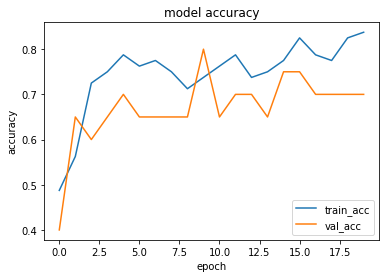

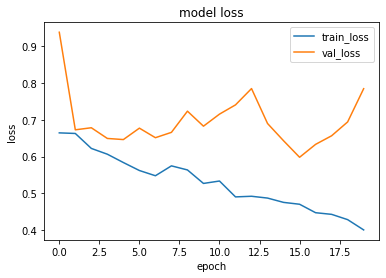

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.49336728]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.48930696]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_2.mov is [[0.6264322]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4218026]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.34568885]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.34539825]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.7271 - accuracy: 0.4750 - precision_59: 0.4906 - recall_59: 0.6341 - val_loss: 0.6664 - val_accuracy: 0.6000 - val_precision_59: 0.6667 - val_recall_59: 0.2222
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6688 - accuracy: 0.6375 - precision_59: 0.8333 - recall_59: 0.3659 - val_loss: 0.6570 - val_accuracy: 0.5000 - val_precision_59: 0.4706 - val_recall_59: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6425 - accuracy: 0.6000 - precision_59: 0.5652 - recall_59: 0.9512 - val_loss: 0.6538 - val_accuracy: 0.7000 - val_precision_59: 0.6154 - val_recall_59: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.5874 - accuracy: 0.7125 - precision_59: 0.6875 - recall_59: 0.8049 - val_loss: 0.6067 - val_accuracy: 0.7500 - val_precision_59: 0.7000 - val_recall_59: 0.7778
Epoch 5/75


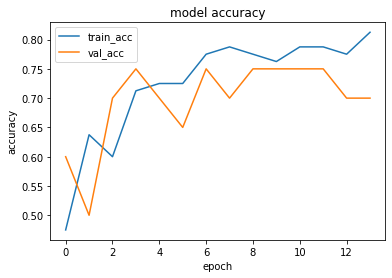

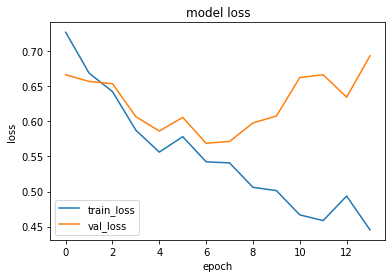

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.28172955]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.8358669]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.81266797]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.23689002]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.21824673]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.21841928]]
Epoch 1/75
3/3 [==============================] - 0s 167ms/step - loss: 0.7251 - accuracy: 0.5250 - precision_60: 0.5082 - recall_60: 0.7949 - val_loss: 0.6446 - val_accuracy: 0.6500 - val_precision_60: 0.8333 - val_recall_60: 0.4545
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6432 - accuracy: 0.7625 - precision_60: 0.7381 - recall_60: 0.7949 - val_loss: 0.6009 - val_accuracy: 0.8000 - val_precision_60: 0.8889 - val_recall_60: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5873 - accuracy: 0.7750 - precision_60: 0.7561 - recall_60: 0.7949 - val_loss: 0.6546 - val_accuracy: 0.7500 - val_precision_60: 0.8000 - val_recall_60: 0.7273
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.5780 - accuracy: 0.7500 - precision_60: 0.7568 - recall_60: 0.7179 - val_loss: 0.7593 - val_accuracy: 0.7500 - val_precision_60: 0.8750 - val_recall_60: 0.6364
Epoch 5/75


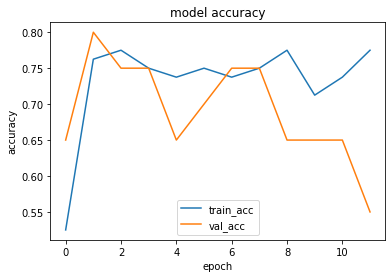

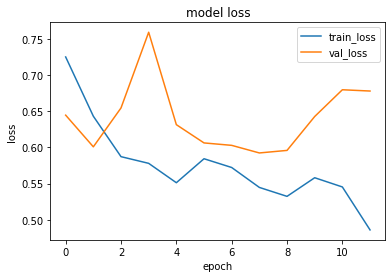

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.30408686]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.8369107]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.7748388]]


1it [00:00, 9341.43it/s]


prediction for video control_1.mov is [[0.21004036]]


1it [00:00, 11650.84it/s]


prediction for video control_2.mov is [[0.38899213]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.18912953]]
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.7198 - accuracy: 0.4625 - precision_61: 0.3750 - recall_61: 0.1538 - val_loss: 0.6447 - val_accuracy: 0.7500 - val_precision_61: 0.7500 - val_recall_61: 0.8182
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.7142 - accuracy: 0.6375 - precision_61: 0.5893 - recall_61: 0.8462 - val_loss: 0.6310 - val_accuracy: 0.6500 - val_precision_61: 0.6429 - val_recall_61: 0.8182
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6585 - accuracy: 0.6875 - precision_61: 0.6750 - recall_61: 0.6923 - val_loss: 0.6029 - val_accuracy: 0.7500 - val_precision_61: 0.7500 - val_recall_61: 0.8182
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6502 - accuracy: 0.6750 - precision_61: 0.7600 - recall_61: 0.4872 - val_loss: 0.5771 - val_accuracy: 0.8000 - val_precision_61: 0.8182 - val_recall_61: 0.8182
Epoch 5/75


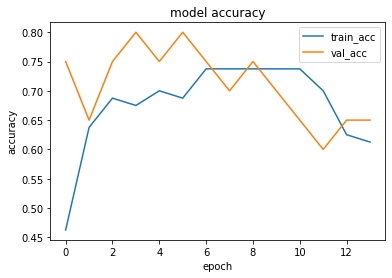

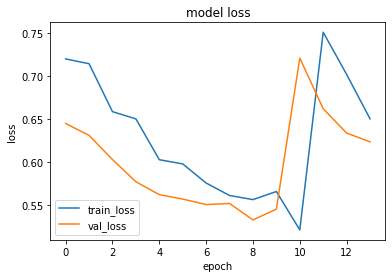

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.5638937]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.69760984]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.57861966]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.55985796]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.5578179]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.55818135]]


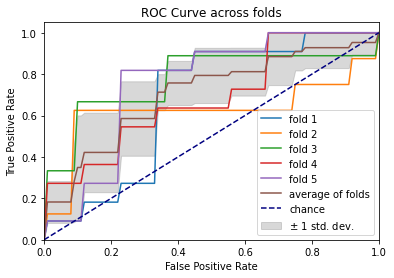

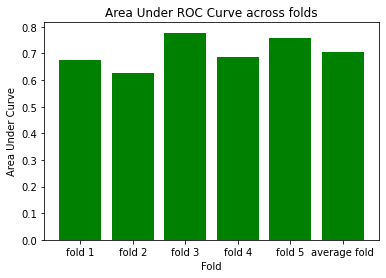

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

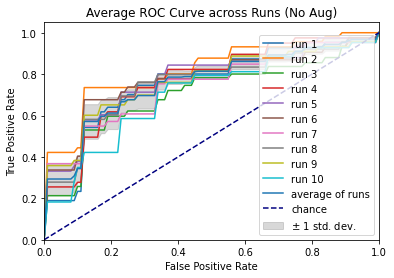

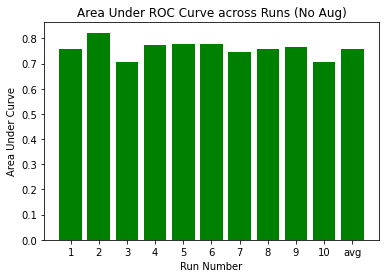

In [27]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101))

In [32]:
[func(AVERAGE_AUROCS) for func in [np.mean, np.std]]

[0.7591477272727274, 0.0316149689426786]